<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_09_auto_ml_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Generate Data

In [56]:
import pandas as pd

COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_2020_apr'

ORIG_FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

TARGET_MONTH_YEAR = pd.datetime(2020,4,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()


In [57]:
if COLAB:
  !pip install -U featuretools
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  !cd dl-projects && ls
else:
  !pip install -U featuretools

Requirement already up-to-date: featuretools in /usr/local/lib/python3.6/dist-packages (0.17.0)
Cloning into 'dl-projects'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 2031 (delta 27), reused 17 (delta 6), pack-reused 1977
Receiving objects: 100% (2031/2031), 79.06 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (1252/1252), done.
01_01_tensor.ipynb	       04_04_auto_ml_4.ipynb	06_stats.ipynb
01_02_correlation.ipynb        04_05_auto_ml_0.ipynb	07_algebra.ipynb
01_03_preprocessing.ipynb      04_05_auto_ml_1.ipynb	08_probability.ipynb
01_04_numpy.ipynb	       04_05_auto_ml_2.ipynb	09_evaluation.ipynb
01_05_parallelization.ipynb    04_06_auto_ml_1.ipynb	50_RL.ipynb
01_06_pandas.ipynb	       04_06_auto_ml_2.ipynb	999_Links.ipynb
01_07_python_0.ipynb	       04_06_auto_ml_3.ipynb	archive
01_07_python_1.ipynb	       04_06_auto_ml_4.ipynb	d01_download.ipynb
01_07_python_2.ipynb	       04_

In [58]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [59]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib
import re

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [61]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [62]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

In [64]:
data = format_tabular(ORIGIN_DATASET)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107847 entries, 0 to 107846
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   DrawNo     107847 non-null  int64         
 1   DrawDate   107847 non-null  datetime64[ns]
 2   PrizeType  107847 non-null  object        
 3   LuckyNo    107847 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


In [66]:
data.tail(24)

,DrawNo,DrawDate,PrizeType,LuckyNo
107823,513520,2020-07-01,SpecialNo9,1303
107824,513620,2020-07-04,1stPrizeNo,2999
107825,513620,2020-07-04,2ndPrizeNo,115
107826,513620,2020-07-04,3rdPrizeNo,5808
107827,513620,2020-07-04,ConsolationNo1,6792
107828,513620,2020-07-04,ConsolationNo10,5049
107829,513620,2020-07-04,ConsolationNo2,9926
107830,513620,2020-07-04,ConsolationNo3,8257
107831,513620,2020-07-04,ConsolationNo4,7643
107832,513620,2020-07-04,ConsolationNo5,204


In [67]:
data['NumberId'] = data['LuckyNo']

In [68]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
107837,513620,2020-07-04,SpecialNo1,8800,8800
107838,513620,2020-07-04,SpecialNo10,2761,2761
107839,513620,2020-07-04,SpecialNo2,793,793
107840,513620,2020-07-04,SpecialNo3,4488,4488
107841,513620,2020-07-04,SpecialNo4,9952,9952
107842,513620,2020-07-04,SpecialNo5,1671,1671
107843,513620,2020-07-04,SpecialNo6,3808,3808
107844,513620,2020-07-04,SpecialNo7,1011,1011
107845,513620,2020-07-04,SpecialNo8,2639,2639
107846,513620,2020-07-04,SpecialNo9,3009,3009


## Data Cleansing

In [69]:
def change_prize_type(x):
  return "Prize"
  # if "Special" in x:
  #   return 'Prize'
  # elif "Consolation" in x:
  #   return 'Prize'
  # else:
  #   return x

def increment_draw_date(x):
  x = x + relativedelta(minutes=1)
  return x

data['PrizeType'] = data['PrizeType'].apply(change_prize_type)

# Add 1 minutes to draw date to avoid overlapping with the cut off date
data['DrawDate'] = data['DrawDate'].apply(increment_draw_date)

In [70]:
data.tail(23)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
107824,513620,2020-07-04 00:01:00,Prize,2999,2999
107825,513620,2020-07-04 00:01:00,Prize,115,115
107826,513620,2020-07-04 00:01:00,Prize,5808,5808
107827,513620,2020-07-04 00:01:00,Prize,6792,6792
107828,513620,2020-07-04 00:01:00,Prize,5049,5049
107829,513620,2020-07-04 00:01:00,Prize,9926,9926
107830,513620,2020-07-04 00:01:00,Prize,8257,8257
107831,513620,2020-07-04 00:01:00,Prize,7643,7643
107832,513620,2020-07-04 00:01:00,Prize,204,204
107833,513620,2020-07-04 00:01:00,Prize,6606,6606


In [71]:
data.describe().round(2)

,DrawNo,LuckyNo,NumberId
count,107847.00,107847.00,107847.00
mean,275206.90,4974.36,4974.36
std,135384.78,2885.66,2885.66
min,40792.00,0.00,0.00
25%,157999.00,2463.00,2463.00
50%,275206.00,4952.00,4952.00
75%,392413.00,7465.00,7465.00
max,513620.00,9999.00,9999.00


Text(0.5, 1.0, 'Draw')

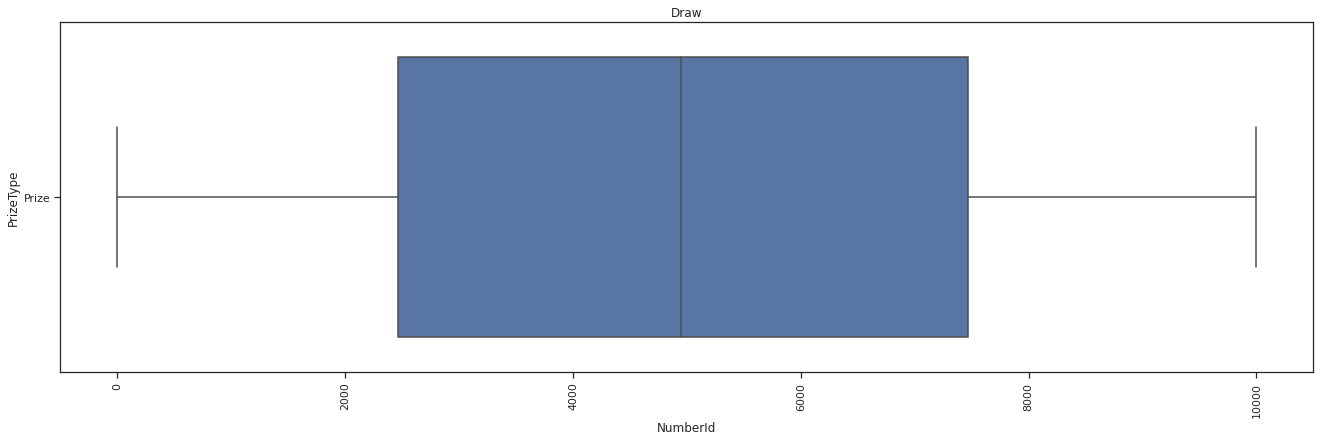

In [72]:
plt.figure(figsize=(20,6))
sns.boxplot(x='NumberId', y='PrizeType',data=data)
plt.xticks(rotation=90)
plt.title('Draw')

# print(data[data['NumberId']==1760])

## Making Labels

In [73]:
data['TotalStrike'] = 1
data.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,40792,1992-05-06 00:01:00,Prize,19,19,1
1,40792,1992-05-06 00:01:00,Prize,1124,1124,1
2,40792,1992-05-06 00:01:00,Prize,592,592,1
3,40792,1992-05-06 00:01:00,Prize,5311,5311,1
4,40792,1992-05-06 00:01:00,Prize,407,407,1
5,40792,1992-05-06 00:01:00,Prize,1949,1949,1
6,40792,1992-05-06 00:01:00,Prize,1606,1606,1
7,40792,1992-05-06 00:01:00,Prize,3775,3775,1
8,40792,1992-05-06 00:01:00,Prize,6226,6226,1
9,40792,1992-05-06 00:01:00,Prize,1271,1271,1


In [74]:
def make_cutoffs(start_date, end_date, threshold=0):
    # Find numbers exist before start date
    number_pool = data[data['DrawDate'] < start_date]['NumberId'].unique()
    tmp = pd.DataFrame({'NumberId': number_pool})
   
    # For numbers in the number pool, find their strike count between the start and end dates
    strike_counts = data[(data['NumberId'].isin(number_pool)) & 
        (data['DrawDate'] >= start_date) & 
        (data['DrawDate']< end_date)
    ].groupby('NumberId')['TotalStrike'].count().reset_index()
    
    number_of_draws = data[
                 (data['DrawDate'] >= start_date) & 
                 (data['DrawDate']< end_date)]['DrawDate'].nunique()
    # display(strike_counts)
    # print(number_of_draws)
    
    # Merge with all the number ids to record all customers who existed before start date
    strike_counts = strike_counts.merge(tmp, on='NumberId', how='right')
    
    # Set the total for any numbers who did not strike in the timeframe equal to 0
    strike_counts['TotalStrike'] = strike_counts['TotalStrike'].fillna(0)
    
    # Label is based on the threshold
    strike_counts['Label'] = (strike_counts['TotalStrike'] > threshold).astype(int)
        
    # The cutoff time is the start date
    strike_counts['time'] = pd.to_datetime(start_date)
    strike_counts = strike_counts[['NumberId', 'time', 'TotalStrike', 'Label']]
    
    #display(strike_counts[strike_counts['Label']==1].nunique())
    #display(strike_counts.sort_values(by='TotalStrike', ascending=False))
   
    return number_of_draws, strike_counts

In [75]:
# For testing purpose
#data = data[data['DrawDate'] < TARGET_MONTH_YEAR]

In [76]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
107837,513620,2020-07-04 00:01:00,Prize,8800,8800,1
107838,513620,2020-07-04 00:01:00,Prize,2761,2761,1
107839,513620,2020-07-04 00:01:00,Prize,793,793,1
107840,513620,2020-07-04 00:01:00,Prize,4488,4488,1
107841,513620,2020-07-04 00:01:00,Prize,9952,9952,1
107842,513620,2020-07-04 00:01:00,Prize,1671,1671,1
107843,513620,2020-07-04 00:01:00,Prize,3808,3808,1
107844,513620,2020-07-04 00:01:00,Prize,1011,1011,1
107845,513620,2020-07-04 00:01:00,Prize,2639,2639,1
107846,513620,2020-07-04 00:01:00,Prize,3009,3009,1


In [77]:
end_month_year = TARGET_MONTH_YEAR +  relativedelta(months=1)
end_month_year

datetime.datetime(2020, 5, 1, 0, 0)

In [78]:
number_of_draws, target_month_year = make_cutoffs(TARGET_MONTH_YEAR, end_month_year)
print(number_of_draws, len(target_month_year))
target_month_year[(target_month_year['Label']==1) & (target_month_year['TotalStrike']==2)].sort_values(by='TotalStrike', ascending=False).head()

0 10000


,NumberId,time,TotalStrike,Label


In [79]:
data[data['NumberId'].isin([203])]

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
27574,160599,1999-12-05 00:01:00,Prize,203,203,1
35044,193101,2001-12-09 00:01:00,Prize,203,203,1
42342,224803,2003-11-16 00:01:00,Prize,203,203,1
52887,270706,2006-07-26 00:01:00,Prize,203,203,1
78724,383013,2013-02-02 00:01:00,Prize,203,203,1
80375,390213,2013-06-26 00:01:00,Prize,203,203,1
82995,401614,2014-02-15 00:01:00,Prize,203,203,1
90708,435116,2016-01-03 00:01:00,Prize,203,203,1
92863,444516,2016-07-13 00:01:00,Prize,203,203,1
96465,460217,2017-05-28 00:01:00,Prize,203,203,1


Text(0.5, 1.0, 'Label Distribution for Target Month Year')

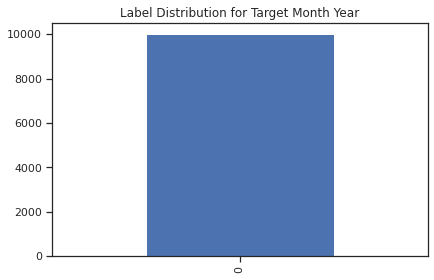

In [80]:
target_month_year['Label'].value_counts().plot.bar()
plt.title('Label Distribution for Target Month Year')

In [81]:
CUT_OFF_YEAR = TARGET_MONTH_YEAR

In [82]:
## Loop through each month starting from CUT_OFF_YEAR

# print(data['DrawDate'].max())
max_year_month = TARGET_MONTH_YEAR  + relativedelta(day=31)
print(f"Max month year: {max_year_month}")

start_year_month = CUT_OFF_YEAR

months_data = []
total_draws = 0
while start_year_month < max_year_month:
    start_date = start_year_month 
    end_date = start_date + relativedelta(months=1)
    start_year_month = start_year_month + relativedelta(months=1)
    print(f"Labels from {start_date} to {end_date}")
    draw_count, month_data = make_cutoffs(start_date, end_date)
    total_draws = total_draws + draw_count
    months_data.append(month_data)

print(f"Total draws: {total_draws}")
print(f"Total draws: {data[(data['DrawDate'] >= CUT_OFF_YEAR) & (data['DrawDate'] <= max_year_month)]['DrawDate'].nunique()}")
print(f"Total months:{len(months_data)}")
print(f"Total records count: {sum([len(l) for l in months_data])}")
print([len(l) for l in months_data])

Max month year: 2020-04-30 00:00:00
Labels from 2020-04-01 00:00:00 to 2020-05-01 00:00:00
Total draws: 0
Total draws: 0
Total months:1
Total records count: 10000
[10000]


In [83]:
labels = pd.concat(months_data)
labels.to_csv(DATASET_PATH/'labels.csv')
labels.describe()

,NumberId,TotalStrike,Label
count,10000.00000,10000.0,10000.0
mean,4999.50000,0.0,0.0
std,2886.89568,0.0,0.0
min,0.00000,0.0,0.0
25%,2499.75000,0.0,0.0
50%,4999.50000,0.0,0.0
75%,7499.25000,0.0,0.0
max,9999.00000,0.0,0.0


In [84]:
labels.NumberId.nunique(), labels.head(10)

(10000,    NumberId       time  TotalStrike  Label
 0        19 2020-04-01          0.0      0
 1      1124 2020-04-01          0.0      0
 2       592 2020-04-01          0.0      0
 3      5311 2020-04-01          0.0      0
 4       407 2020-04-01          0.0      0
 5      1949 2020-04-01          0.0      0
 6      1606 2020-04-01          0.0      0
 7      3775 2020-04-01          0.0      0
 8      6226 2020-04-01          0.0      0
 9      1271 2020-04-01          0.0      0)

In [85]:
labels.tail(10)

,NumberId,time,TotalStrike,Label
9990,3479,2020-04-01,0.0,0
9991,6512,2020-04-01,0.0,0
9992,4996,2020-04-01,0.0,0
9993,3852,2020-04-01,0.0,0
9994,7940,2020-04-01,0.0,0
9995,5407,2020-04-01,0.0,0
9996,7709,2020-04-01,0.0,0
9997,9604,2020-04-01,0.0,0
9998,9659,2020-04-01,0.0,0
9999,5488,2020-04-01,0.0,0


## Automated Feature Engineering

In [86]:
es = ft.EntitySet(id="Lotto Results")

# Add the entire data table as an entity
es.entity_from_dataframe("Results",
                         dataframe=data,
                         index="results_index",
                         time_index = 'DrawDate')

es['Results']

2020-07-06 13:57:40,948 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: Results
  Variables:
    results_index (dtype: index)
    DrawNo (dtype: numeric)
    DrawDate (dtype: datetime_time_index)
    PrizeType (dtype: categorical)
    LuckyNo (dtype: numeric)
    NumberId (dtype: numeric)
    TotalStrike (dtype: numeric)
  Shape:
    (Rows: 107847, Columns: 7)

In [87]:
es.normalize_entity(new_entity_id="Numbers",
                    base_entity_id="Results",
                    index="NumberId",
                    )

Entityset: Lotto Results
  Entities:
    Results [Rows: 107847, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [88]:
es

Entityset: Lotto Results
  Entities:
    Results [Rows: 107847, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [89]:
es['Numbers'].df.head(24)

,NumberId,first_Results_time
19,19,1992-05-06 00:01:00
1124,1124,1992-05-06 00:01:00
592,592,1992-05-06 00:01:00
5311,5311,1992-05-06 00:01:00
407,407,1992-05-06 00:01:00
1949,1949,1992-05-06 00:01:00
1606,1606,1992-05-06 00:01:00
3775,3775,1992-05-06 00:01:00
6226,6226,1992-05-06 00:01:00
1271,1271,1992-05-06 00:01:00


In [90]:
es['Results'].df.head(24)

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,0,40792,1992-05-06 00:01:00,Prize,19,19,1
1,1,40792,1992-05-06 00:01:00,Prize,1124,1124,1
2,2,40792,1992-05-06 00:01:00,Prize,592,592,1
3,3,40792,1992-05-06 00:01:00,Prize,5311,5311,1
4,4,40792,1992-05-06 00:01:00,Prize,407,407,1
5,5,40792,1992-05-06 00:01:00,Prize,1949,1949,1
6,6,40792,1992-05-06 00:01:00,Prize,1606,1606,1
7,7,40792,1992-05-06 00:01:00,Prize,3775,3775,1
8,8,40792,1992-05-06 00:01:00,Prize,6226,6226,1
9,9,40792,1992-05-06 00:01:00,Prize,1271,1271,1


In [91]:
len(es['Results'].df)

107847

## Deep Feature Synthesis

In [92]:
# feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
#                                         cutoff_time = labels, verbose = 2,
#                                         cutoff_time_in_index = True,
#                                         chunk_size = len(labels), n_jobs = 1,
#                                         max_depth = 1)
print(ft.__version__)
ft.list_primitives().T

0.17.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
name,n_most_common,num_true,entropy,max,mode,time_since_first,all,sum,count,last,std,median,avg_time_between,percent_true,num_unique,min,trend,time_since_last,mean,any,first,skew,divide_numeric,greater_than_equal_to_scalar,percentile,absolute,greater_than_scalar,multiply_numeric_scalar,negate,isin,is_null,scalar_subtract_numeric_feature,cum_min,num_words,subtract_numeric,cum_count,add_numeric,weekday,hour,not_equal,or,year,equal,modulo_by_feature,week,haversine,less_than_equal_to,modulo_numeric,second,day,divide_numeric_scalar,latitude,less_than,greater_than_equal_to,less_than_scalar,longitude,multiply_boolean,not,time_since_previous,diff,greater_than,multiply_numeric,cum_max,subtract_numeric_scalar,time_since,cum_mean,add_numeric_scalar,num_characters,cum_sum,is_weekend,not_equal_scalar,and,equal_scalar,month,age,less_than_equal_to_scalar,minute,modulo_numeric_scalar,divide_by_feature
type,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform
dask_compatible,False,True,False,True,False,False,True,True,True,False,True,False,False,True,True,True,False,False,True,True,False,False,True,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True,True,False,True,True,False,True,True,False,True,True,True,True,True,False,True,True,True,False,True,True,False,False,True,True,False,True,True,False,True,True,False,True,True,True,True,True,False,True,True,True,True
description,Determines the `n` most common elements.,Counts the number of `True` values.,Calculates the entropy for a categorical variable,"Calculates the highest value, ignoring `NaN` v...",Determines the most commonly repeated value.,Calculates the time elapsed since the first da...,Calculates if all values are 'True' in a list.,"Calculates the total addition, ignoring `NaN`.","Determines the total number of values, excludi...",Determines the last value in a list.,Computes the dispersion relative to the mean v...,Determines the middlemost number in a list of ...,Computes the average number of seconds between...,Determines the percent of `True` values.,"Determines the number of distinct values, igno...","Calculates the smallest value, ignoring `NaN` ...",Calculates the trend of a variable over time.,Calculates the time elapsed since the last dat...,Computes the average for a list of values.,Determines if any value is 'True' in a list.,Determines the first value in a list.,Computes the extent to which a distribution di...,Element-wise division of two lists.,Determines if values are greater than or equal...,Determines the percentile rank for each value ...,Computes the absolute value of a number.,Determines if values are greater than a given ...,Multiply each element in the list by a scalar.,Negates a numeric value.,Determines whether a value is present in a pro...,Determines if a value is null.,Subtract each value in the list from a given s...,Calculates the cumulative minimum.,Determines the number of words in a string by ...,Element-wise subtraction of two lists.,Calcul

In [93]:
# default_agg_primitives =  ['std', 'max', 'min', 'mode', 'mean', 'skew', 'last', 'avg_time_between', 
#                            'count', 'sum', 'trend', 'percent_true', 'num_unique', 'time_since_last', 
#                            'time_since_first']
# default_trans_primitives =  ['cum_sum', 'cum_mean', 'month', 'day', 'percentile', 
#                               'time_since', 'time_since_previous', 'cum_min', 'cum_max']

default_agg_primitives =  ['std', 'max', 'min', 'mode', 'mean', 'skew', 'last', 'avg_time_between', 
                           'count', 'sum', 'trend', 'percent_true', 'num_unique']
default_trans_primitives =  ['cum_sum', 'cum_mean', 'month', 'day', 'percentile', 
                            'and', 'time_since', 'time_since_previous']

feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
                                        agg_primitives = default_agg_primitives ,
                                        trans_primitives = default_trans_primitives,
                                        cutoff_time = labels, verbose = 1,
                                        cutoff_time_in_index = True,
                                        chunk_size = len(labels), n_jobs = 1,
                                        #chunk_size = 10000, n_jobs = -1,
                                        max_depth = 2)

Built 211 features
Elapsed: 08:48 | Progress: 100%|██████████


In [94]:
len(feature_matrix.columns), feature_matrix.columns

(213, Index(['STD(Results.LuckyNo)', 'STD(Results.DrawNo)',
        'STD(Results.TotalStrike)', 'MAX(Results.LuckyNo)',
        'MAX(Results.DrawNo)', 'MAX(Results.TotalStrike)',
        'MIN(Results.LuckyNo)', 'MIN(Results.DrawNo)',
        'MIN(Results.TotalStrike)', 'MODE(Results.PrizeType)',
        ...
        'PERCENTILE(MAX(Results.DrawNo))', 'PERCENTILE(STD(Results.DrawNo))',
        'PERCENTILE(SKEW(Results.LuckyNo))',
        'PERCENTILE(LAST(Results.TotalStrike))',
        'PERCENTILE(MIN(Results.DrawNo))',
        'PERCENTILE(MAX(Results.TotalStrike))',
        'PERCENTILE(LAST(Results.DrawNo))', 'PERCENTILE(SKEW(Results.DrawNo))',
        'TotalStrike', 'Label'],
       dtype='object', length=213))

In [95]:
len(feature_matrix)

10000

In [96]:
feature_matrix.head().T

NumberId,19,1124,592,5311,407
time,2020-04-01,2020-04-01,2020-04-01,2020-04-01,2020-04-01
STD(Results.LuckyNo),0,0,0,0,0
STD(Results.DrawNo),153048,149115,139261,149149,176871
STD(Results.TotalStrike),0,0,0,0,0
MAX(Results.LuckyNo),19,1124,592,5311,407
MAX(Results.DrawNo),464417,468517,465317,494219,497819
...,...,...,...,...,...
PERCENTILE(MAX(Results.TotalStrike)),0.50005,0.50005,0.50005,0.50005,0.50005
PERCENTILE(LAST(Results.DrawNo)),0.3575,0.3946,0.3652,0.7173,0.77585
PERCENTILE(SKEW(Results.DrawNo)),0.440408,0.110978,0.191434,0.473431,0.306014


In [97]:
feature_matrix.shape

(10000, 213)

In [98]:
feature_matrix.head(2)

,,STD(Results.LuckyNo),STD(Results.DrawNo),STD(Results.TotalStrike),MAX(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MIN(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MODE(Results.PrizeType),MEAN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),SKEW(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),LAST(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.PrizeType),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.DrawNo),SUM(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(DrawNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),...,CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate)),CUM_MEAN(MAX(Results.DrawNo)),CUM_MEAN(STD(Results.DrawNo)),CUM_MEAN(SKEW(Results.LuckyNo)),CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(MIN(Results.DrawNo)),CUM_MEAN(MAX(Results.TotalStrike)),CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(SKEW(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(COUNT(Results)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),TotalStrike,Label
NumberId,time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19,2020-04-01,0.0,153047.954707,0.0,19,464417,1,19,40792,1,Prize,19,267562.761905,1,0.0,-0.072923,0.0,19,97437,464417,Prize,1,39934080.0,21,399,5618818,21,0.0,0.031955,0.0,1,5,6,880588740.0,NaN,9.440443e+09,0.326936,0.0,76519.422044,2.872941e+08,35199.652464,...,39934080.0,464417.0,153047.954707,0.0,1.0,40792.0,1.0,464417.0,-0.072923,8,27,0.339838,0.99685,0.0020,0.0043,0.0020,0.0020,0.50005,0.50005,0.50005,0.50005,0.0020,0.50005,0.4324,0.9897,0.50005,0.50005,0.50005,0.99685,0.0109,0.3575,0.8140,0.50005,0.50005,0.0012,0.50005,0.3575,0.440408,0.0,0
1124,2020-04-01,0.0,149114.505460,0.0,1124,468517,1,1124,40792,1,Prize,1124,321027.000000,1,0.0,-0.661895,0.0,1124,98380,468517,Prize,1,80585280.0,11,12364,3531297,11,0.0,0.032205,0.0,1,5,6,880588740.0,0.0,9.827976e+09,0.318534,0.0,74553.124902,2.777359e+08,34296.646677,...,60259680.0,466467.0,151081.230084,0.0,1.0,40792.0,1.0,466467.0,-0.367409,11,18,0.651956,0.54860,0.1125,0.1223,0.1125,0.1125,0.50005,0.50005,0.50005,0.50005,0.1125,0.50005,0.8589,0.7300,0.50005,0.50005,0.50005,0.54860,0.5978,0.3946,0.7572,0.50005,0.50005,0.0012,0.50005,0.3946,0.110978,0.0,0


In [99]:
#feature_matrix[(feature_matrix['NumberId']==0) & (feature_matrix['Label']==1)].head(10)

## Correlations

In [100]:
# Save the original feature matrix
origin_feature_matrix = feature_matrix

feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(10000, 215)

In [101]:
feature_matrix.head(10)

,NumberId,time,STD(Results.LuckyNo),STD(Results.DrawNo),STD(Results.TotalStrike),MAX(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MIN(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MEAN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),SKEW(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),LAST(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.DrawNo),SUM(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(DrawNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),...,CUM_MEAN(STD(Results.DrawNo)),CUM_MEAN(SKEW(Results.LuckyNo)),CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(MIN(Results.DrawNo)),CUM_MEAN(MAX(Results.TotalStrike)),CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(SKEW(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(COUNT(Results)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
0,19,2020-04-01,0.0,153047.954707,0.0,19,464417,1,19,40792,1,19,267562.761905,1,0.0,-0.072923,0.0,19,97437,464417,1,3.993408e+07,21,399,5618818,21,0.0,0.031955,0.0,1,5,6,880588740.0,NaN,9.440443e+09,0.326936,0.0,76519.422044,2.872941e+08,35199.652464,...,153047.954707,0.0,1.0,40792.0,1.0,464417.000000,-0.072923,8,27,0.339838,0.99685,0.0020,0.0043,0.0020,0.0020,0.50005,0.50005,0.50005,0.50005,0.0020,0.50005,0.43240,0.9897,0.50005,0.50005,0.50005,0.99685,0.01090,0.35750,0.8140,0.50005,0.50005,0.0012,0.50005,0.35750,0.440408,0.0,0,1,1
1,1124,2020-04-01,0.0,149114.505460,0.0,1124,468517,1,1124,40792,1,1124,321027.000000,1,0.0,-0.661895,0.0,1124,98380,468517,1,8.058528e+07,11,12364,3531297,11,0.0,0.032205,0.0,1,5,6,880588740.0,0.0,9.827976e+09,0.318534,0.0,74553.124902,2.777359e+08,34296.646677,...,151081.230084,0.0,1.0,40792.0,1.0,466467.000000,-0.367409,11,18,0.651956,0.54860,0.1125,0.1223,0.1125,0.1125,0.50005,0.50005,0.50005,0.50005,0.1125,0.50005,0.85890,0.7300,0.50005,0.50005,0.50005,0.54860,0.59780,0.39460,0.7572,0.50005,0.50005,0.0012,0.50005,0.39460,0.110978,0.0,0,1,1
2,592,2020-04-01,0.0,139261.320490,0.0,592,465317,1,592,40792,1,592,277062.375000,1,0.0,-0.464576,0.0,592,97649,465317,1,5.334336e+07,16,9472,4432998,16,0.0,0.031779,0.0,1,5,6,880588740.0,0.0,8.260651e+09,0.297486,0.0,69629.453339,2.628327e+08,32030.735419,...,147141.260219,0.0,1.0,40792.0,1.0,466083.666667,-0.399798,9,13,0.171320,0.93630,0.0593,0.0952,0.0593,0.0593,0.50005,0.50005,0.50005,0.50005,0.0593,0.50005,0.52280,0.9203,0.50005,0.50005,0.50005,0.93630,0.12030,0.36520,0.5875,0.50005,0.50005,0.0012,0.50005,0.36520,0.191434,0.0,0,1,1
3,53

In [102]:
corrs = feature_matrix.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

NumberId                   NaN
STD(Results.LuckyNo)       NaN
STD(Results.DrawNo)        NaN
STD(Results.TotalStrike)   NaN
MAX(Results.LuckyNo)       NaN
Name: TotalStrike, dtype: float64

In [103]:
corrs['TotalStrike'].dropna().tail(60)

Series([], Name: TotalStrike, dtype: float64)

In [104]:
feature_matrix['month'] = feature_matrix['time'].dt.month
feature_matrix['year'] = feature_matrix['time'].dt.year

In [105]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 217 entries, NumberId to year
dtypes: datetime64[ns](1), float64(155), int64(59), uint8(2)
memory usage: 16.4 MB


In [106]:
feature_matrix.head()

,NumberId,time,STD(Results.LuckyNo),STD(Results.DrawNo),STD(Results.TotalStrike),MAX(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MIN(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MEAN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),SKEW(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),LAST(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.DrawNo),SUM(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(DrawNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(MIN(Results.DrawNo)),CUM_MEAN(MAX(Results.TotalStrike)),CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(SKEW(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(COUNT(Results)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
0,19,2020-04-01,0.0,153047.954707,0.0,19,464417,1,19,40792,1,19,267562.761905,1,0.0,-0.072923,0.0,19,97437,464417,1,39934080.0,21,399,5618818,21,0.0,0.031955,0.0,1,5,6,880588740.0,NaN,9.440443e+09,0.326936,0.0,76519.422044,2.872941e+08,35199.652464,...,1.0,40792.0,1.0,464417.000000,-0.072923,8,27,0.339838,0.99685,0.0020,0.0043,0.0020,0.0020,0.50005,0.50005,0.50005,0.50005,0.0020,0.50005,0.4324,0.9897,0.50005,0.50005,0.50005,0.99685,0.01090,0.35750,0.8140,0.50005,0.50005,0.0012,0.50005,0.35750,0.440408,0.0,0,1,1,4,2020
1,1124,2020-04-01,0.0,149114.505460,0.0,1124,468517,1,1124,40792,1,1124,321027.000000,1,0.0,-0.661895,0.0,1124,98380,468517,1,80585280.0,11,12364,3531297,11,0.0,0.032205,0.0,1,5,6,880588740.0,0.0,9.827976e+09,0.318534,0.0,74553.124902,2.777359e+08,34296.646677,...,1.0,40792.0,1.0,466467.000000,-0.367409,11,18,0.651956,0.54860,0.1125,0.1223,0.1125,0.1125,0.50005,0.50005,0.50005,0.50005,0.1125,0.50005,0.8589,0.7300,0.50005,0.50005,0.50005,0.54860,0.59780,0.39460,0.7572,0.50005,0.50005,0.0012,0.50005,0.39460,0.110978,0.0,0,1,1,4,2020
2,592,2020-04-01,0.0,139261.320490,0.0,592,465317,1,592,40792,1,592,277062.375000,1,0.0,-0.464576,0.0,592,97649,465317,1,53343360.0,16,9472,4432998,16,0.0,0.031779,0.0,1,5,6,880588740.0,0.0,8.260651e+09,0.297486,0.0,69629.453339,2.628327e+08,32030.735419,...,1.0,40792.0,1.0,466083.666667,-0.399798,9,13,0.171320,0.93630,0.0593,0.0952,0.0593,0.0593,0.50005,0.50005,0.50005,0.50005,0.0593,0.50005,0.5228,0.9203,0.50005,0.50005,0.50005,0.93630,0.12030,0.36520,0.5875,0.50005,0.50005,0.0012,0.50005,0.36520,0.191434,0.0,0,1,1,4,2020
3,5311,2020-04-01,0.0,149149.256699,0.0,5311,494219,1,5311,40792,1,5311,255355.000000,1,0.0,-0.03

In [107]:
feature_matrix.tail()

,NumberId,time,STD(Results.LuckyNo),STD(Results.DrawNo),STD(Results.TotalStrike),MAX(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MIN(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MEAN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),SKEW(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),LAST(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.DrawNo),SUM(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(DrawNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(MIN(Results.DrawNo)),CUM_MEAN(MAX(Results.TotalStrike)),CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(SKEW(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(COUNT(Results)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
9995,5407,2020-04-01,0.0,33816.271769,0.0,5407,426715,1,5407,366112,1,5407,405080.666667,1,0.0,-1.700598,0.0,5407,88778,426715,1,5.365440e+07,3,16221,1215242,3,0.0,0.033921,0.0,1,2,19,256089540.0,12787200.0,3.074048e+09,0.072238,0.0,16897.356249,5.981441e+07,7771.970235,...,1.0,83861.495198,1.0,465778.188876,0.002597,7,15,0.999700,0.00350,0.5408,0.1644,0.5408,0.5408,0.50005,0.50005,0.50005,0.50005,0.5408,0.50005,0.9978,0.0273,0.50005,0.50005,0.50005,0.00350,0.12510,0.14920,0.0007,0.50005,0.50005,0.9996,0.50005,0.14920,0.005704,0.0,0,1,1,4,2020
9996,7709,2020-04-01,0.0,39368.855047,0.0,7709,501619,1,7709,373212,1,7709,438690.500000,1,0.0,0.112795,0.0,7709,105992,501619,1,3.264686e+07,8,61672,3509524,8,0.0,0.033760,0.0,1,7,15,243388740.0,12700800.0,3.992931e+09,0.084099,0.0,19687.520845,6.996679e+07,9055.400179,...,1.0,83890.438932,1.0,465781.774032,0.002608,10,12,0.997798,0.20630,0.7710,0.6238,0.7710,0.7710,0.50005,0.50005,0.50005,0.50005,0.7710,0.50005,0.9998,0.7242,0.50005,0.50005,0.50005,0.20630,0.00140,0.84770,0.0011,0.50005,0.50005,0.9997,0.50005,0.84770,0.585410,0.0,0,1,1,4,2020
9997,9604,2020-04-01,0.0,60184.617182,0.0,9604,504619,1,9604,394813,1,9604,463950.333333,1,0.0,-1.652326,0.0,9604,106679,504619,1,9.789120e+07,3,28812,1391851,3,0.0,0.033742,0.0,1,10,1,205113540.0,38275200.0,6.191282e+09,0.128565,0.0,30085.535476,1.070193e+08,13838.054740,...,1.0,83921.537407,1.0,465785.658532,0.002443,12,15,0.997598,0.00350,0.9605,0.2960,0.9605,0.9605,0.50005,0.50005,0.50005,0.50005,0.9605,0.50005,1.0000,0.0466,0.50005,0.50005,0.50005,0.00350,0.79115,0.90800,0.0056,0.50005,0.50005,0.9998,0.50005,0.90800,0.006805,0.0,0,1,1,4,2020
9998,9659,2020-04-01,0.0,30474.905

In [108]:
display(feature_matrix.describe())

,NumberId,STD(Results.LuckyNo),STD(Results.DrawNo),STD(Results.TotalStrike),MAX(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MIN(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MEAN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),SKEW(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),LAST(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.DrawNo),SUM(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(DrawNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(MIN(Results.DrawNo)),CUM_MEAN(MAX(Results.TotalStrike)),CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(SKEW(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(COUNT(Results)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
count,10000.00000,10000.0,10000.000000,10000.0,10000.00000,10000.000000,10000.0,10000.00000,10000.000000,10000.0,10000.00000,10000.000000,10000.0,9993.0,9993.000000,9993.0,10000.00000,10000.000000,10000.000000,10000.0,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,9993.0,9993.000000,9993.0,10000.0,10000.000000,10000.000000,1.000000e+04,9.999000e+03,1.000000e+04,10000.000000,10000.0,10000.000000,1.000000e+04,10000.000000,10000.000000,...,10000.0,10000.000000,10000.0,10000.000000,9993.000000,10000.000000,10000.00000,9993.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9.993000e+03,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,9.993000e+03,9.993000e+03,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,9.993000e+03,1.000000e+04,10000.000000,1.000000e+04,10000.000000,9993.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,4999.50000,0.0,133231.354507,0.0,4999.50000,465787.374900,1.0,4999.50000,83988.676000,1.0,4999.50000,274757.556905,1.0,0.0,0.002538,0.0,4999.50000,97754.229800,465787.374900,1.0,8.164165e+07,10.766300,53552.798800,2.958580e+06,10.766300,0.0,0.032094,0.0,1.0,6.671400,15.660900,7.940237e+08,7.276472e+04,8.582011e+09,0.284595,0.0,66611.635485,2.490930e+08,30640.327319,10.941889,...,1.0,56170.123455,1.0,465533.913887,0.005151,6.537700,15.68840,0.500050,0.500050,0.500050,0.500050,0.500050,0.500050,5.000500e-01,5.000500e-01,5.000500e-01,5.000500e-01,0.500050,5.000500e-01,0.500050,0.500050,5.000500e-01,5.000500e-01,5.000500e-01,0.500050,0.500050,0.500050,0.500050,5.000500e-01,5.000500e-01,0.500050,5.000500e-01,0.500050,

## Save feature matrix

In [109]:
# https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
if COLAB:
    #!ls /content/gdrive/My\ Drive/
    feature_matrix.to_feather(DATASET)
    origin_feature_matrix.to_pickle(DATASET_PATH/f"{FEATURE_DATASET_PREFIX}_orig.pkl")

In [110]:
if COLAB:
  !cd gdrive/"My Drive"/datasets/ && ls -l --block-size=M

total 4882M
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr.ft
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr_orig.pkl
-rw------- 1 root root   17M Mar  1 05:47 feature_matrix_2020_feb.ft
-rw------- 1 root root   17M Mar  1 05:39 feature_matrix_2020_jan.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_june.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_june_orig.pkl
-rw------- 1 root root   17M Jul  6 13:56 feature_matrix_2020_mar.ft
-rw------- 1 root root   17M Jul  6 13:56 feature_matrix_2020_mar_orig.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
-rw------- 1 root root   17M Feb 21 13:07 feature_matrix_snapshot.ft
-rw------- 1 root root    1M Jul  6 13:57 labels.csv
-rw------- 1 root root    5M Jan 30 04:33 orig_X_test.ft
-rw------- 1 root root  415M Jan 30 04:33 orig_X_train.ft
-rw------- 1 root root    1M Jan 30 04:33 orig_